Quick look at pre-release v3.1 results

Runs in here:
* Previous baselines
    * `retro_baseline_v2.0_10yrs.db` (like v1.x runs)
    * `baseline_v2.0_10yrs.db`
    * `baseline_v2.1_10yrs.db`
    * `baseline_v2.2_10yrs.db`
    * `baseline_v3.0_10yrs.db`
* `starter_v3.1_10yrs.db`
    * update to the footprint to include small Euclid swath
    * update survey start time
    * uzy filter swapping rather than just uz
    * updated to newer cloud database
    * telescope now parks with r-filter in. Should be no filter change time added when coming out of park.
    * updated long gaps survey to only attempt log gaps if early pair was sucessful
    * blobs no longer have az and radius limits (mostly a change for visulization)
    

Runs below are like starter_v3.1 except how noted.

* `m2_starter`
    * same as `starter`, but run on apple silicon. Mostly for checking cross-platform repeatability
* `filtlers_uy`
    * swaps y in for u in bright time
* `filters_uz`
    * swaps z in for u in bright time (like previous baselines)
* `noroll`
    * no rolling candence. Requested by DESC to look at uniformity at data releases
* `old_mjd0_uz`
    * rolling back the survey start date, swapping only u and z filters
* `old_mjd0`
    * rolling back survey start date, swapping u with z & y
* `threeroll`
    * only three seasons of rolling. Looking at final survey uniformity
*  `weather_cloudso...`
    * Varying the start year of our cloud database. Provides a handy way to look at the precision of metric values and the limits to which we can expect to optimize the survey
* `no_plane`, `light_plane`, `heavy_plane`
    * Varying the amount of observing in the dusty plane. Mostly so we can check self calibration schemes. 
* `more_u_utw`
    * Vary the weight on getting u-band templates. Noted starter wasn't doing a great job closing the sky for calibration in year 1



In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:
# download summary file if needed
if not os.path.isfile('summary.h5'):
    import requests
    url = 'https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.1/maf/summary.h5'
    r = requests.get(url)
    open('summary.h5', 'wb').write(r.content)

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(46, 42385)

In [4]:
#data_loaded['Total detected -6.4 LVDwarfs gi UserPointsSlicer']

In [5]:
[col for col in data_loaded.columns if 'LVDwarfs' in col]

['Area M_v>-6.4 LVDwarfs gi HealpixSlicer',
 'Area M_v>0.0 LVDwarfs gi SCP HealpixSlicer',
 'Median LVDwarfs gi SCP HealpixSlicer',
 'Total detected -6.4 LVDwarfs gi UserPointsSlicer',
 'Total detected -7.0 LVDwarfs gi UserPointsSlicer']

In [6]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'best18k parallax HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
             'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',

            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira'}

# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 

In [7]:
data

,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N","SNe, zlim",3x2 i-band,WL Nvis \ni-band,KNe ZTF simple,KNe single model,XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira
baseline_v2.0_10yrs,0.791058,0.184088,0.3116,0.4284,839.0,99302.532220,0.282012,37.908126,443.0,3433.0,4544.0,1879.0,168086.074111,0.9294,0.642021,0.719635,0.918999,0.588087,0.0039
baseline_v2.1_10yrs,0.806910,0.188258,0.3111,0.4312,838.0,99294.339899,0.283756,38.560143,443.0,3585.0,4777.0,1918.0,163815.013503,0.9286,0.647553,0.723197,0.927567,0.608979,0.0017
baseline_v2.2_10yrs,0.792958,0.186345,0.3212,0.4462,830.0,112802.099640,0.289980,39.794283,440.0,3950.0,5215.0,1920.0,172453.127988,0.9304,0.657476,0.723913,0.933507,0.615265,0.0008
baseline_v3.0_10yrs,0.792666,0.185683,0.3239,0.4559,795.0,109475.798536,0.293926,38.643260,423.0,4308.0,5654.0,1950.0,168032.537231,0.9326,0.642155,0.722293,0.924185,0.611053,0.0376
ddf_split_v3.1_10yrs,0.808772,0.188430,0.3308,0.4670,787.0,117378.779059,0.301080,38.815496,418.0,3414.0,5272.0,1983.0,171938.887809,0.9286,0.635780,0.721438,0.927636,0.606445,0.0452
filters_uy_v3.1_10yrs,0.803276,0.187766,0.3398,0.4708,798.0,120462.917739,0.304223,39.328576,423.0,3555.0,5354.0,2034.0,172653.766759,0.9302,0.641922,0.720541,0.928231,0.596781,0.0429
filters_uz_v3.1_10yrs,0.804189,0.187704,0.3341,0.4671,799.0,117256.351325,0.299039,39.158289,424.0,3798.0,5760.0,1981.0,173159.635926,0.9288,0.642878,0.721987,0.932592,0.618772,0.0508
heavy_plane_v3.1_10yrs,0.791069,0.187303,0.3276,0.4634,718.0,103944.296984,0.293426,37.731486,378.0,3028.0,4716.0,1956.0,179931.625724,0.9266,0.638326,0.722560,0.926570,0.606367,0.0476
light_plane_v3.1_10yrs,0.808896,0.188511,0.3321,0.4577,837.0,125568.129635,0.305550,39.742005,444.0,3735.0,5798.0,1973.0,166686.570924,0.9322,0.642934,0.718737,0.932641,0.621345,0.0487
m2_starter_v3.1_10yrs,0.808044,0.187841,0.3296,0.4633,794.0,117202.638694,0.301566,39.125106,422.0,3634.0,5348.0,2016.0,171659.065254,0.9320,0.639323,0.721868,0.929862,0.599201,0.0477


In [8]:
#data['KNe single model'] # data['KNe ZTF simple']

In [9]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
#data['KNe ZTF simple']

In [10]:
mag_data

,g,i,r,u,y,z
baseline_v2.0_10yrs,26.733479,26.218659,26.755971,25.818916,24.762720,25.510379
baseline_v2.1_10yrs,26.736248,26.252054,26.781543,25.751969,24.728145,25.486640
baseline_v2.2_10yrs,26.753646,26.290929,26.835430,25.724699,24.782743,25.581317
baseline_v3.0_10yrs,26.688123,26.264600,26.818287,25.668262,24.756955,25.524781
ddf_split_v3.1_10yrs,26.687576,26.268533,26.806116,25.668431,24.762111,25.562926
filters_uy_v3.1_10yrs,26.703750,26.286253,26.805307,25.671796,24.763087,25.572446
filters_uz_v3.1_10yrs,26.683522,26.281617,26.830274,25.673077,24.776244,25.555656
heavy_plane_v3.1_10yrs,26.683723,26.262882,26.795542,25.689208,24.750457,25.568224
light_plane_v3.1_10yrs,26.698392,26.295135,26.823447,25.683108,24.787190,25.591887
m2_starter_v3.1_10yrs,26.692768,26.274674,26.809814,25.660805,24.765401,25.566451


In [11]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

,N SN COSMOS,N SN ECDFS,N SN EDFS,N SN ELAISS1,N SN XMM_LSS,zlim COSMOS,zlim ECDFS,zlim EDFS,zlim ELAISS1,zlim XMM_LSS
baseline_v2.0_10yrs,47.333916,5.217382,NaN,81.438800,72.445437,0.596891,0.543027,NaN,0.593426,0.562289
baseline_v2.1_10yrs,21.899369,2.592571,NaN,40.212476,32.838014,0.594427,0.545216,NaN,0.594464,0.561932
baseline_v2.2_10yrs,13.647867,6.881372,NaN,3.753806,NaN,0.514987,0.577431,NaN,0.600156,NaN
baseline_v3.0_10yrs,362.726856,72.383449,74.734786,37.378088,60.363667,0.594675,0.575080,0.526724,0.546128,0.539335
ddf_split_v3.1_10yrs,584.417131,453.575818,807.992831,393.157965,376.111203,0.544945,0.578425,0.514663,0.560445,0.543109
filters_uy_v3.1_10yrs,462.325155,65.335698,221.330970,76.830209,105.459657,0.584417,0.589670,0.519221,0.577674,0.562636
filters_uz_v3.1_10yrs,445.569691,60.704954,215.200600,76.039720,91.293700,0.580354,0.590740,0.506952,0.571387,0.543093
heavy_plane_v3.1_10yrs,567.792466,324.135795,695.176804,302.024294,315.506697,0.570920,0.582374,0.526983,0.573040,0.558683
light_plane_v3.1_10yrs,571.107415,327.595810,695.412297,295.634508,315.134504,0.570913,0.583495,0.526155,0.573830,0.558934
m2_starter_v3.1_10yrs,574.179275,328.443066,697.796420,299.771176,315.201008,0.569473,0.579946,0.527705,0.573196,0.564505


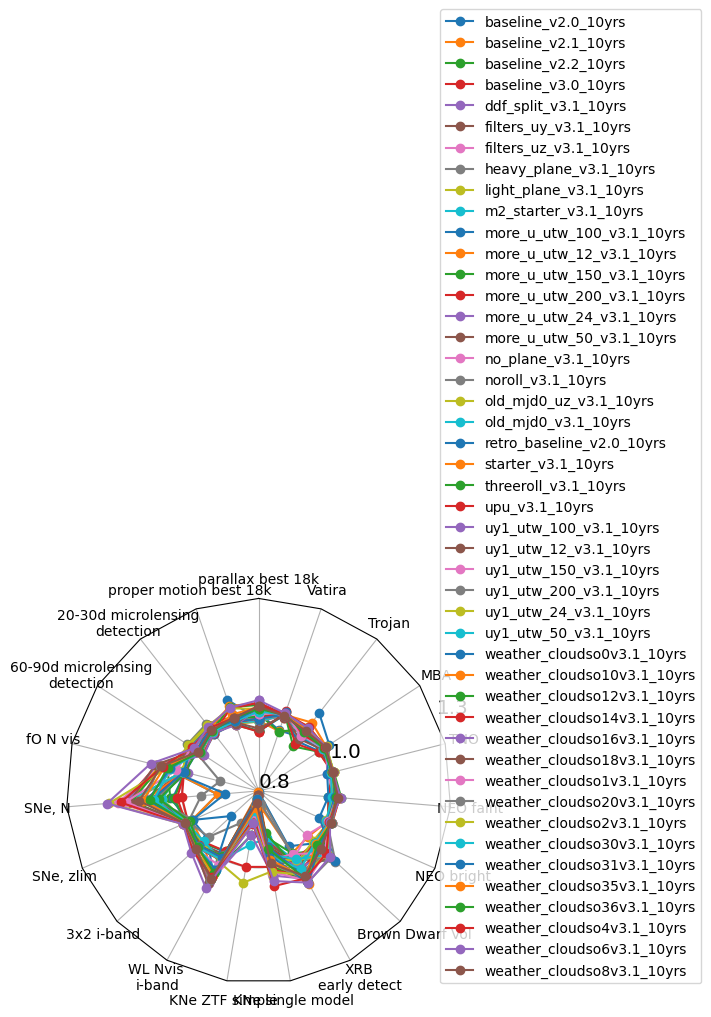

In [12]:
runs = [run for run in data.index ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.3], bbox_to_anchor=(1.65, 0))

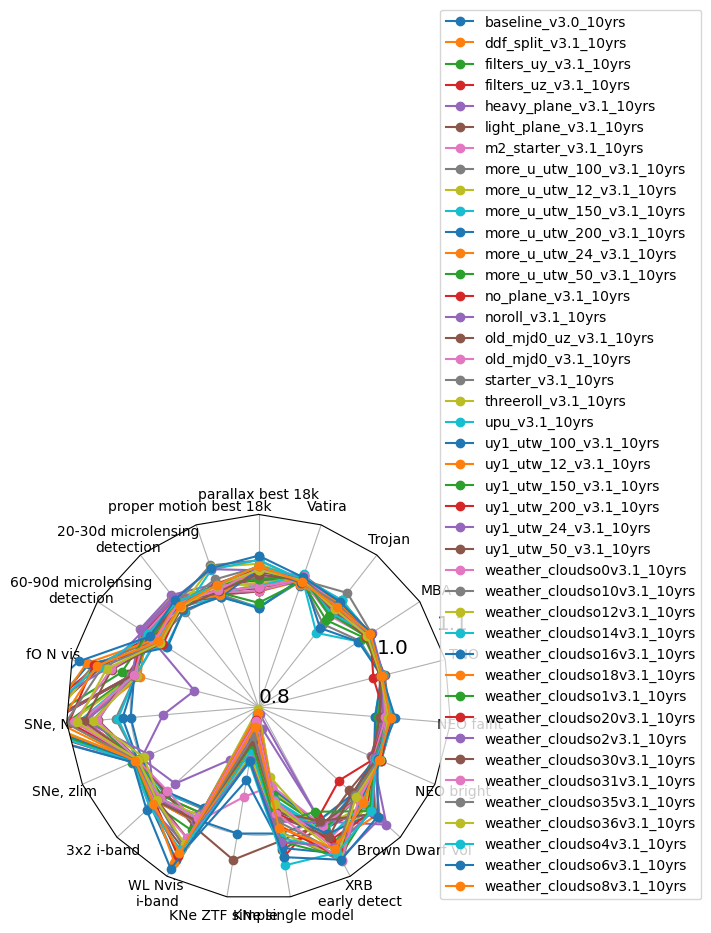

In [13]:
# only 3.x runs

runs = [run for run in data.index if '3.' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

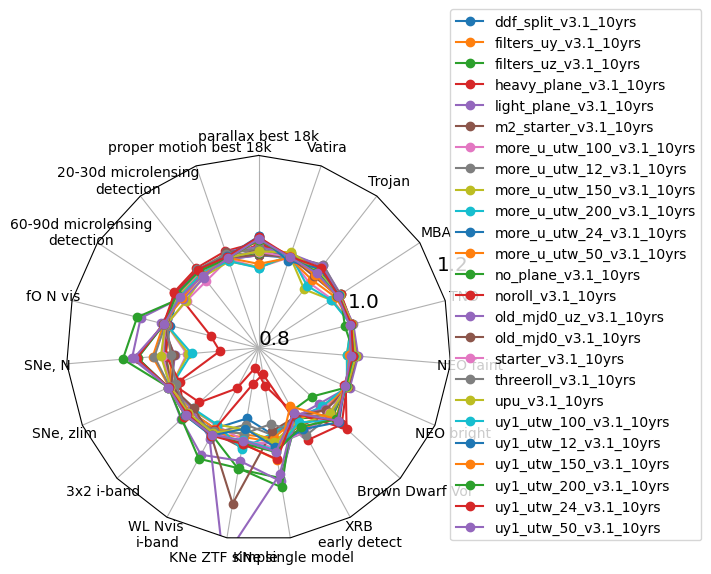

In [14]:
# only 3.1 runs, without the weather

runs = [run for run in data.index if '3.1' in run and 'weather' not in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

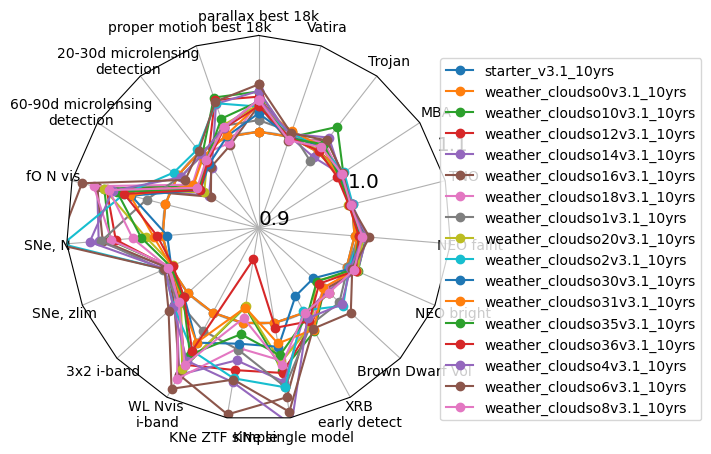

In [15]:
# What happens when we vary the weather?

# 

runs = ['starter_v3.1_10yrs']+ [run for run in data.index if 'weather' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

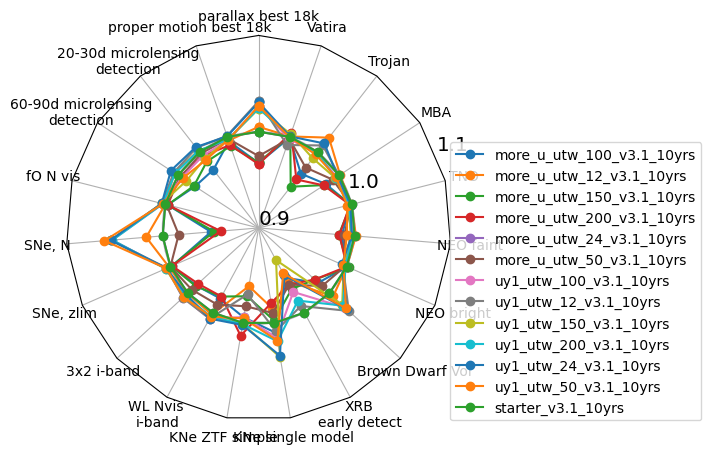

In [16]:
# wow, getting u-band closed in the first year really doesn't seem to help anything! 

runs = [run for run in data.index if '3.1' in run and 'weather' not in run and 'utw' in run] + ['starter_v3.1_10yrs']
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

# Compare 3.1 and 3.0 median coadded depths.
# Changes of order 0.01 mags, so not really any change at all.

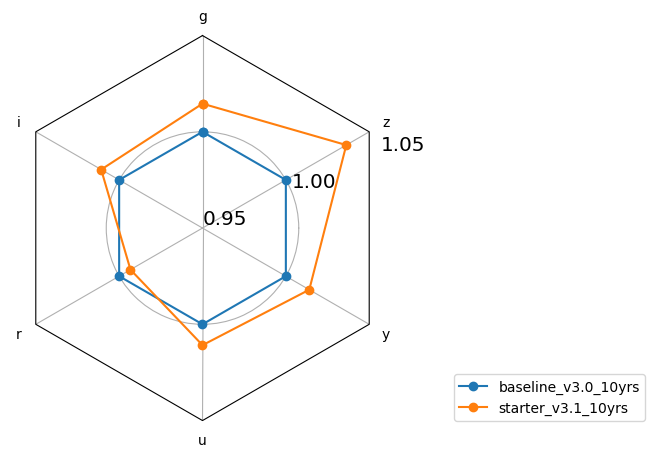

In [17]:
runs = ['baseline_v3.0_10yrs', 'starter_v3.1_10yrs']
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                mag_cols='all', norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

In [18]:
mag_data.loc[runs]

,g,i,r,u,y,z
baseline_v3.0_10yrs,26.688123,26.264600,26.818287,25.668262,24.756955,25.524781
starter_v3.1_10yrs,26.702741,26.275374,26.811500,25.679105,24.771007,25.561028


# Compare number of SNe in the DDFs
# Huge boost in all the DDFs.

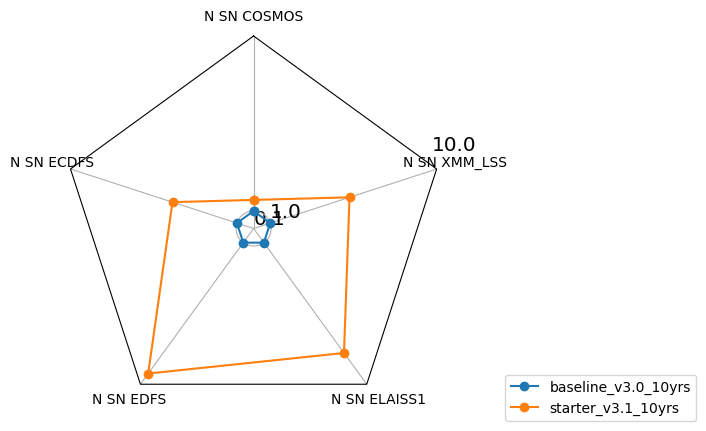

In [19]:
cols = [col for col in ddf_data.columns.values.tolist() if 'N SN' in col]

ndata = norm_df(ddf_data, runs, cols=cols,
                norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.1, 1.0, 10], bbox_to_anchor=(1.65, 0))

# SNe redshift limits in the DDFs. No big changes

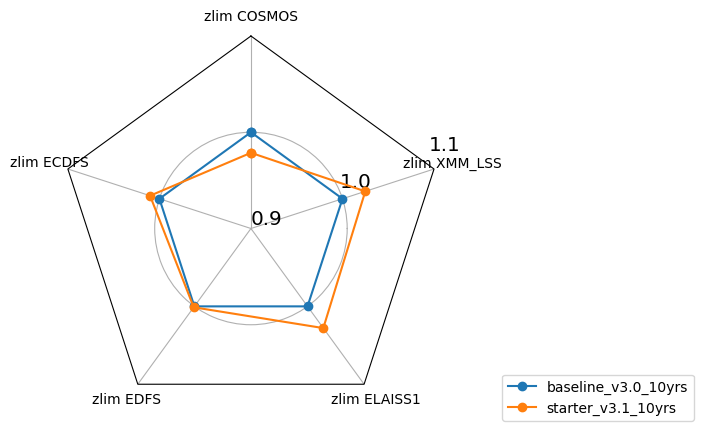

In [20]:
cols = [col for col in ddf_data.columns.values.tolist() if 'zlim' in col]

ndata = norm_df(ddf_data, runs, cols=cols,
                norm_run='baseline_v3.0_10yrs', mag_cols='all')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [21]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs', 'starter_v3.1_10yrs']

In [22]:
sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_data

,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N","SNe, zlim",3x2 i-band,WL Nvis \ni-band,KNe ZTF simple,KNe single model,XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira
retro_baseline_v2.0_10yrs,0.804328,0.176701,0.0883,0.1533,848.0,97124.012102,0.281304,34.632263,449.0,2763.0,3982.0,720.0,179640.718155,0.9048,0.623933,0.705953,0.943433,0.667158,NaN
baseline_v2.0_10yrs,0.791058,0.184088,0.3116,0.4284,839.0,99302.532220,0.282012,37.908126,443.0,3433.0,4544.0,1879.0,168086.074111,0.9294,0.642021,0.719635,0.918999,0.588087,0.0039
baseline_v2.1_10yrs,0.806910,0.188258,0.3111,0.4312,838.0,99294.339899,0.283756,38.560143,443.0,3585.0,4777.0,1918.0,163815.013503,0.9286,0.647553,0.723197,0.927567,0.608979,0.0017
baseline_v2.2_10yrs,0.792958,0.186345,0.3212,0.4462,830.0,112802.099640,0.289980,39.794283,440.0,3950.0,5215.0,1920.0,172453.127988,0.9304,0.657476,0.723913,0.933507,0.615265,0.0008
baseline_v3.0_10yrs,0.792666,0.185683,0.3239,0.4559,795.0,109475.798536,0.293926,38.643260,423.0,4308.0,5654.0,1950.0,168032.537231,0.9326,0.642155,0.722293,0.924185,0.611053,0.0376
starter_v3.1_10yrs,0.802899,0.187499,0.3346,0.4664,795.0,118003.590290,0.301420,39.019244,422.0,3599.0,5363.0,2049.0,171619.716167,0.9288,0.640267,0.721860,0.929189,0.603105,0.0471


# Major science metrics changes over simulation version

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_13799/2527274635.py:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


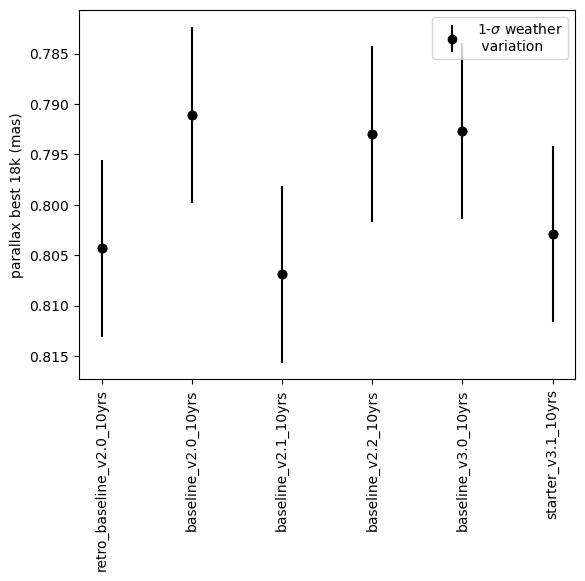

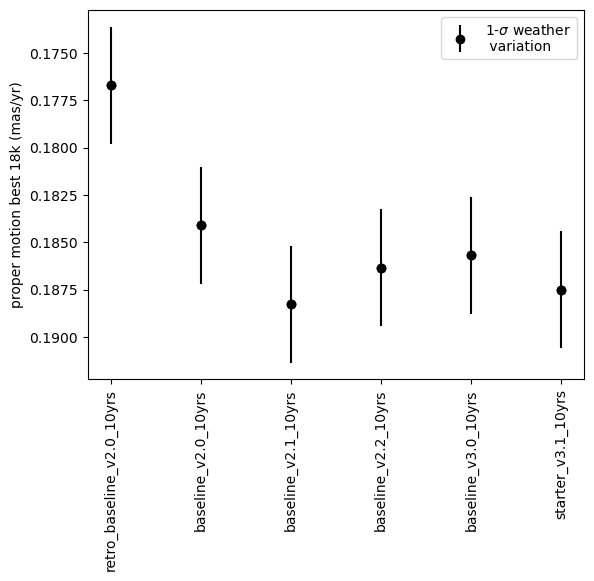

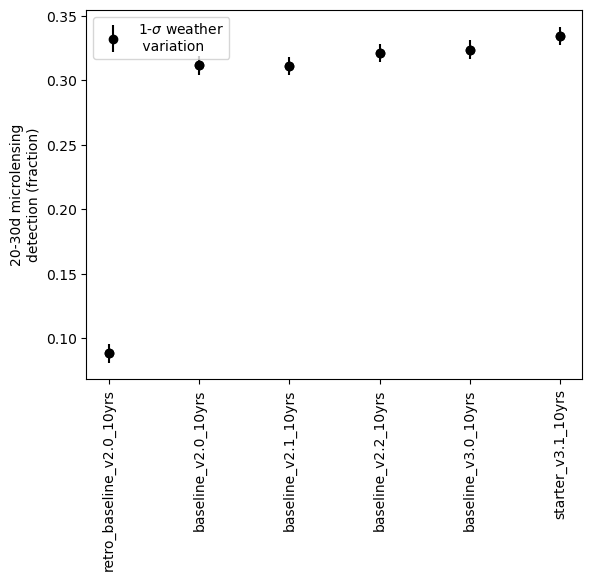

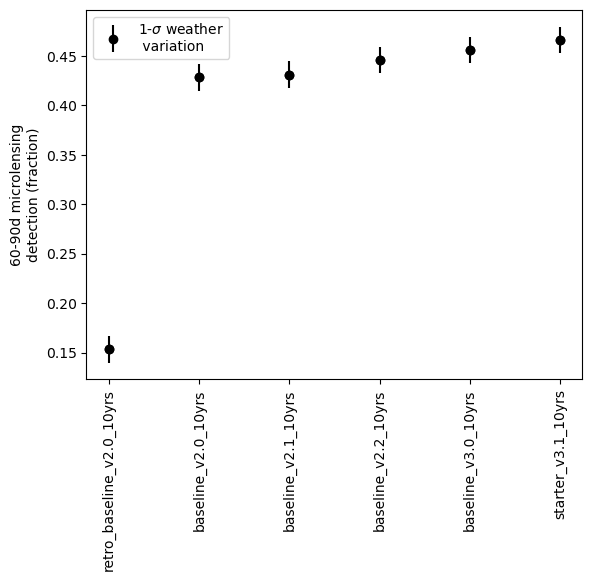

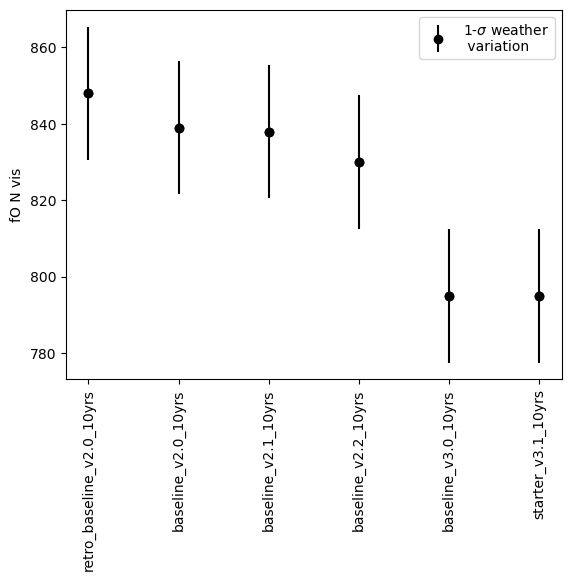

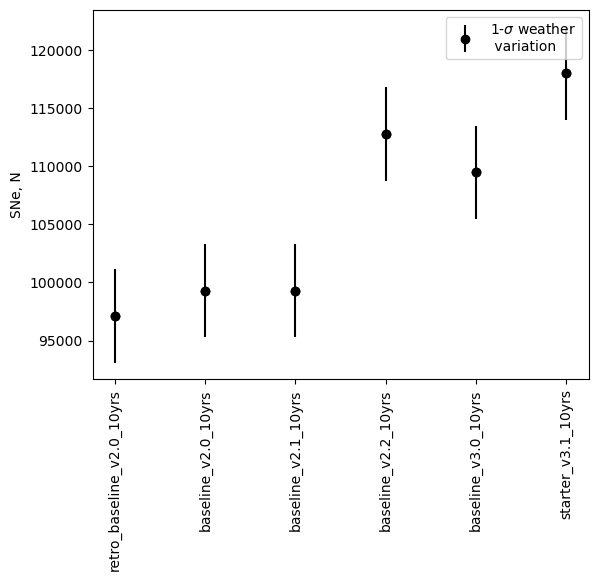

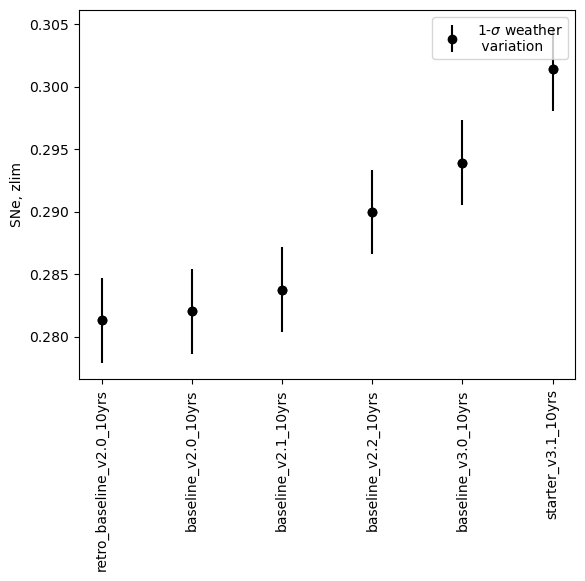

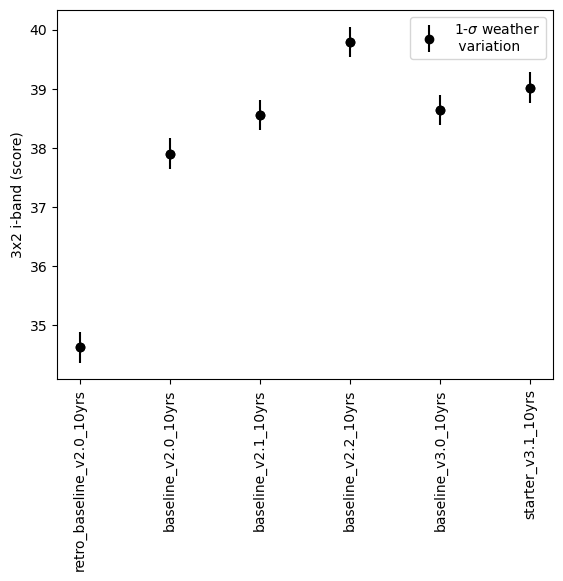

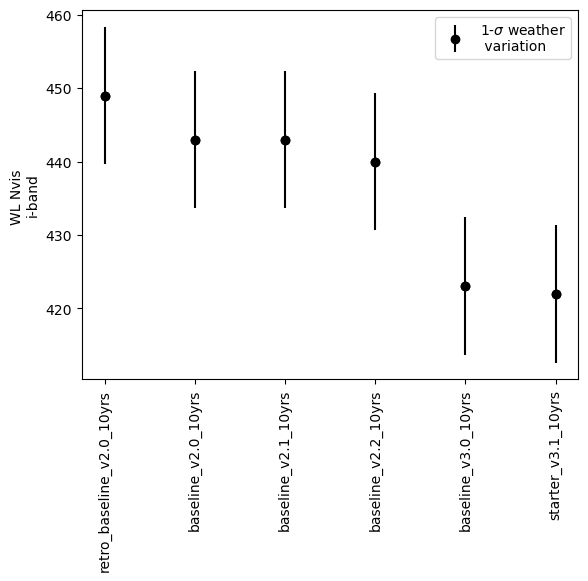

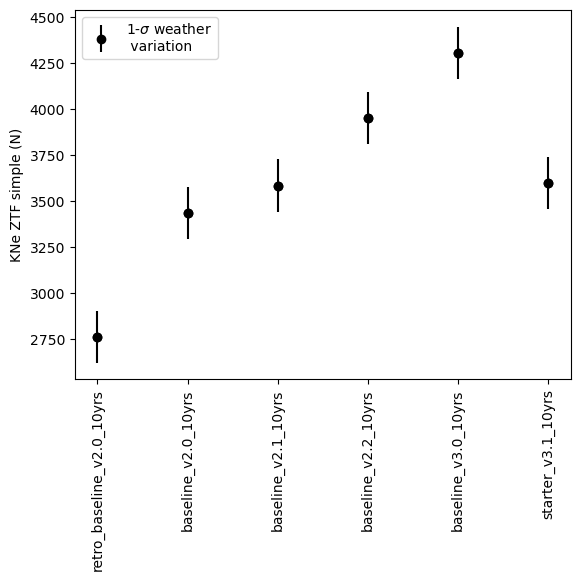

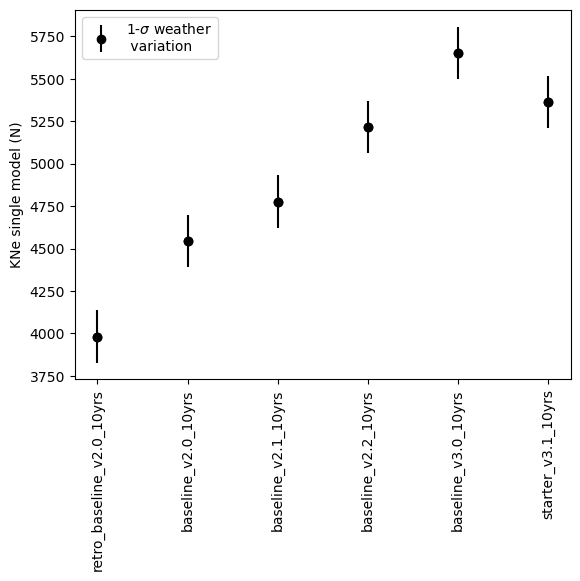

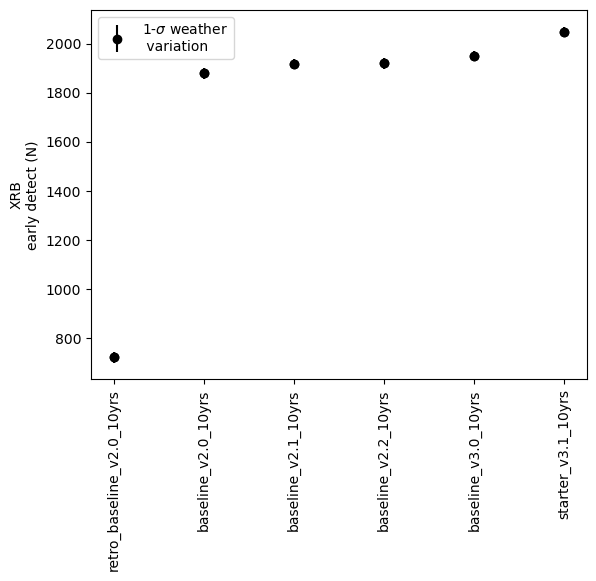

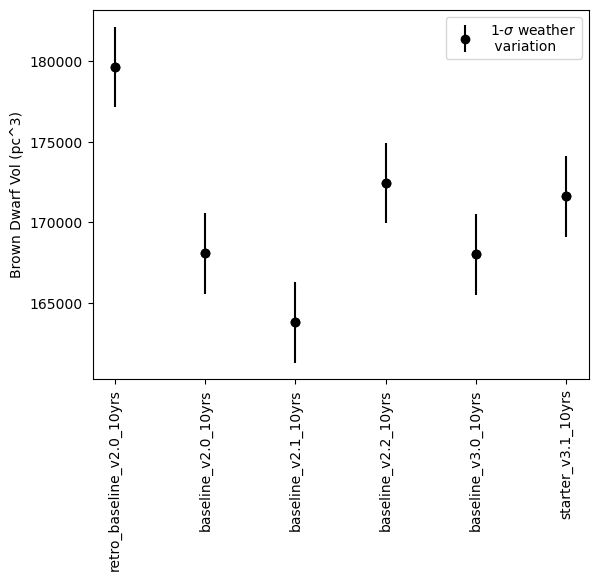

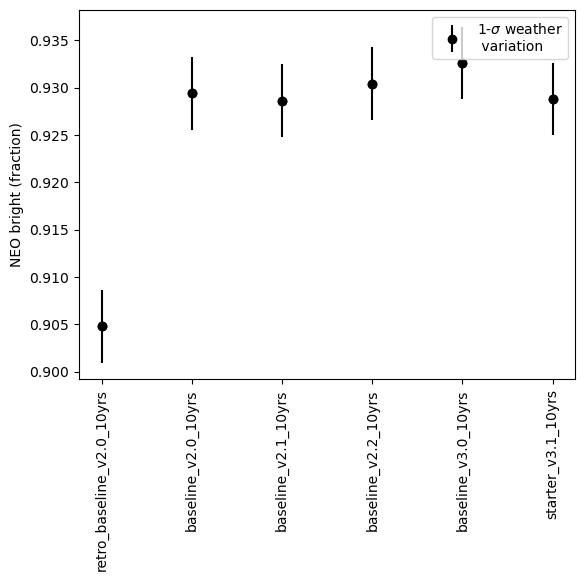

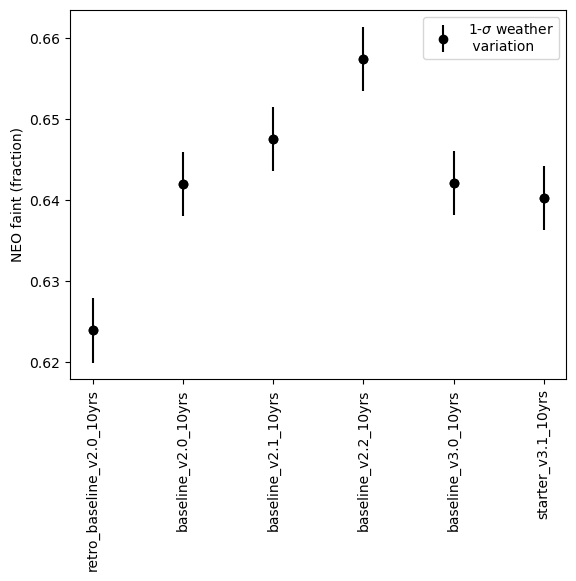

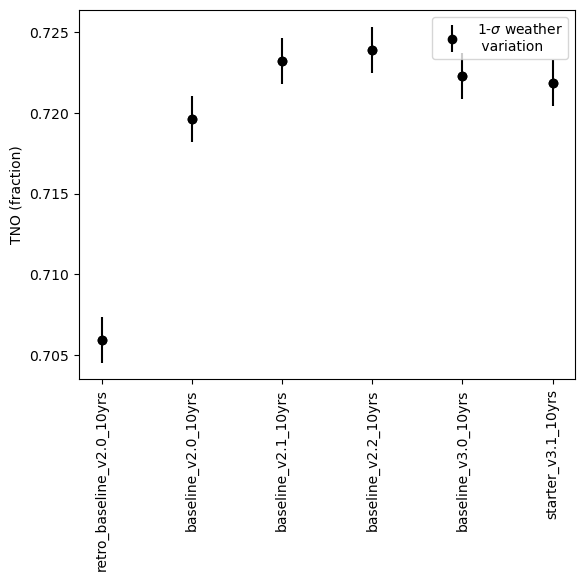

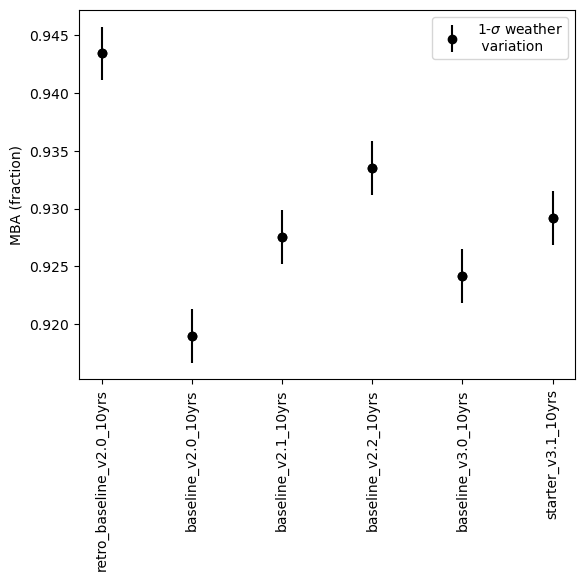

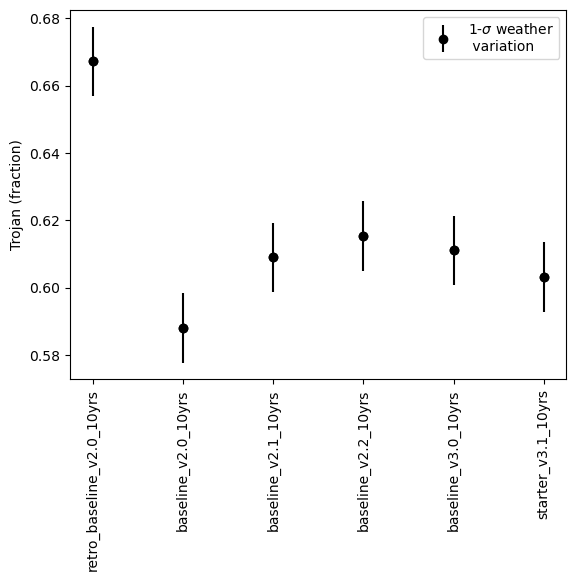

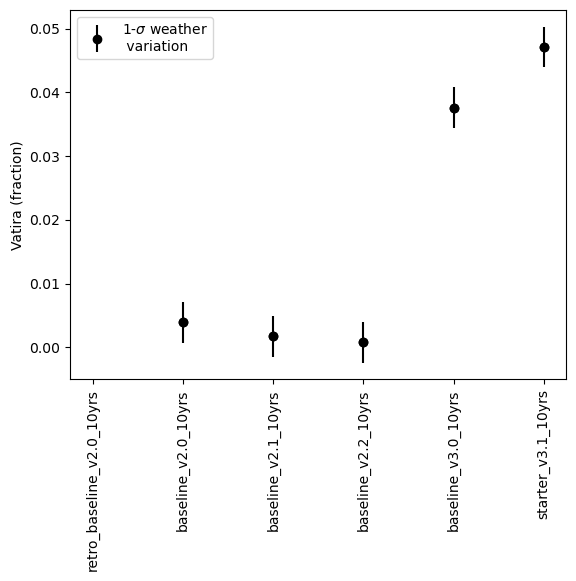

In [23]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])



#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

# DDF performance over simulation version

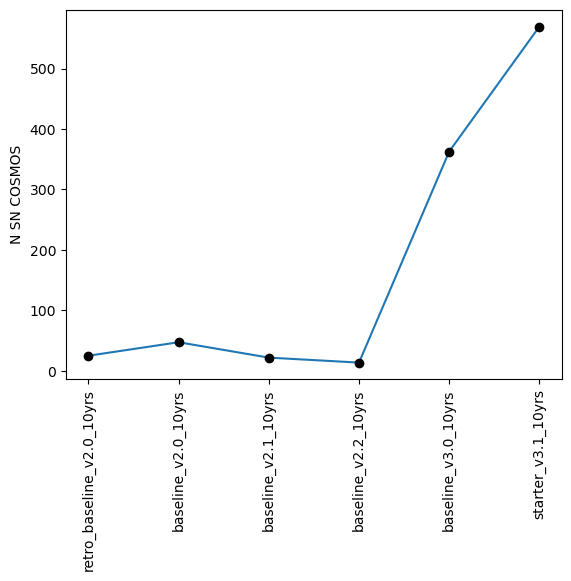

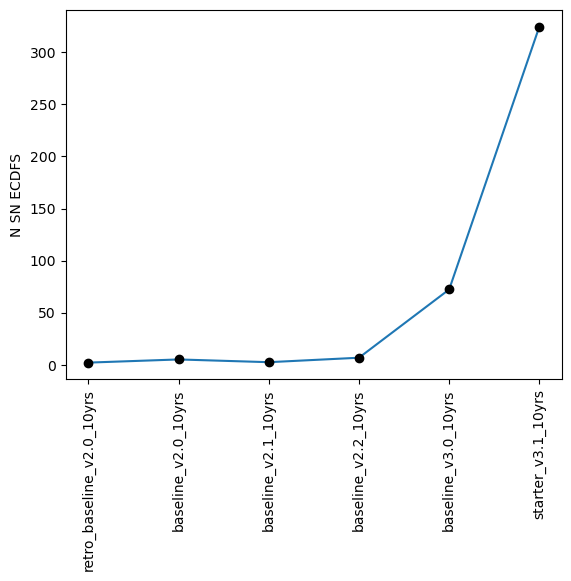

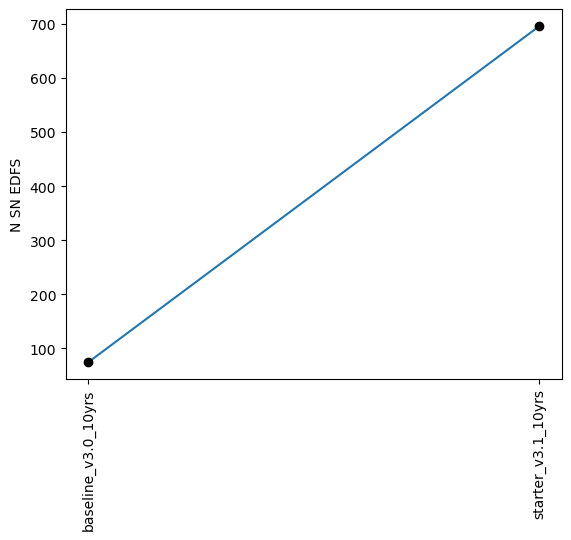

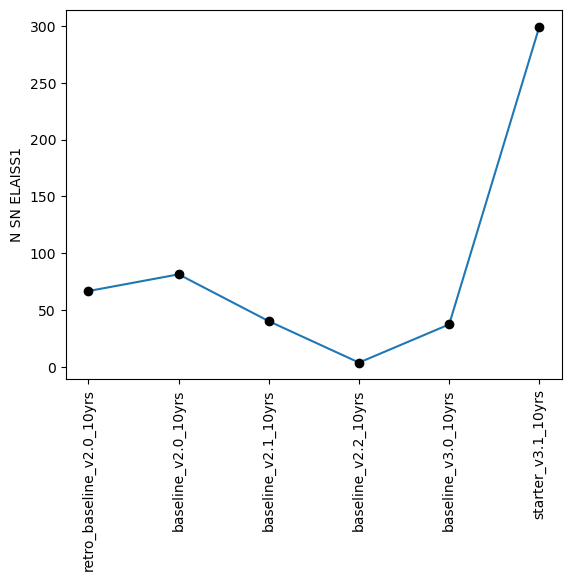

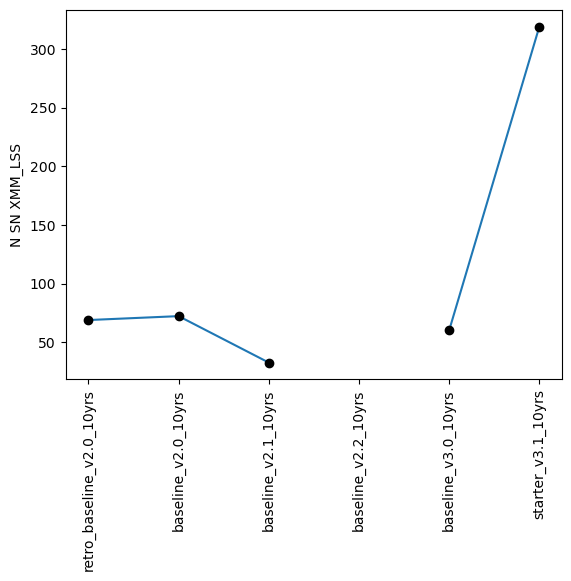

In [24]:

for col in sub_ddf.columns[0:5]:
    fig, ax = plt.subplots()
    ax.plot(sub_ddf[col])
    ax.plot(sub_ddf[col], 'ko')
    ax.set_ylabel(col)
    ax.tick_params(axis='x', labelrotation = 90)

In [25]:
# check that we have the depths and weighted seeing per year
cols = [col for col in data_loaded.columns if 'coadd g' in col and 'Median' in col]
data_loaded.loc['starter_v3.1_10yrs'][cols]

Median coadd g, year<1 night<365 and g HealpixSlicer      25.437954
Median coadd g, year<10 night<3652 and g HealpixSlicer    26.702209
Median coadd g, year<2 night<730 and g HealpixSlicer      25.816188
Median coadd g, year<3 night<1095 and g HealpixSlicer     26.081115
Median coadd g, year<4 night<1461 and g HealpixSlicer     26.261425
Median coadd g, year<5 night<1826 and g HealpixSlicer     26.364062
Median coadd g, year<6 night<2191 and g HealpixSlicer     26.457598
Median coadd g, year<7 night<2556 and g HealpixSlicer     26.533695
Median coadd g, year<8 night<2922 and g HealpixSlicer     26.590688
Median coadd g, year<9 night<3287 and g HealpixSlicer     26.639267
Name: starter_v3.1_10yrs, dtype: float64

In [26]:
cols = [col for col in data_loaded.columns if 'Median SNR-weighted FWHMeff g' in col]
data_loaded.loc['starter_v3.1_10yrs'][cols]

Median SNR-weighted FWHMeff g, year<1 night<365 and g HealpixSlicer      0.912065
Median SNR-weighted FWHMeff g, year<10 night<3652 and g HealpixSlicer    1.081014
Median SNR-weighted FWHMeff g, year<2 night<730 and g HealpixSlicer      0.966896
Median SNR-weighted FWHMeff g, year<3 night<1095 and g HealpixSlicer     0.974440
Median SNR-weighted FWHMeff g, year<4 night<1461 and g HealpixSlicer     0.971924
Median SNR-weighted FWHMeff g, year<5 night<1826 and g HealpixSlicer     0.993859
Median SNR-weighted FWHMeff g, year<6 night<2191 and g HealpixSlicer     1.013314
Median SNR-weighted FWHMeff g, year<7 night<2556 and g HealpixSlicer     1.038812
Median SNR-weighted FWHMeff g, year<8 night<2922 and g HealpixSlicer     1.070360
Median SNR-weighted FWHMeff g, year<9 night<3287 and g HealpixSlicer     1.078749
Name: starter_v3.1_10yrs, dtype: float64

In [27]:
std_dict

{'parallax best 18k': 0.00875901403963322,
 'proper motion best 18k': 0.003085945902581328,
 '20-30d microlensing\ndetection': 0.007162399104874009,
 '60-90d microlensing\ndetection': 0.013301198254292735,
 'fO N vis': 17.44623437163447,
 'SNe, N': 4026.519487737487,
 'SNe, zlim': 0.003384736462547485,
 '3x2 i-band': 0.2597766061607107,
 'WL Nvis \ni-band': 9.385618985980626,
 'KNe ZTF simple': 141.61356694805056,
 'KNe single model': 153.67100358802242,
 'XRB\nearly detect': 21.00288298662829,
 'Brown Dwarf Vol': 2500.2971880499517,
 'NEO bright': 0.003835504367094366,
 'NEO faint': 0.003965414305782611,
 'TNO': 0.0014274727447950583,
 'MBA': 0.0023211485785217026,
 'Trojan': 0.010322942171867276,
 'Vatira': 0.003202922249680751}